# Predicting song danceability using Decision Trees classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
%matplotlib inline

In [2]:
df= pd.read_csv('rock-spotify.csv')

In [3]:
df.columns

Index(['index', 'name', 'artist', 'release_date', 'length', 'popularity',
       'danceability', 'acousticness', 'danceability.1', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness',
       'tempo', 'time_signature', 'valence'],
      dtype='object')

Danceability is measured using a mixture of song features such as beat strength, tempo stability, and overall tempo. The value returned determines the ease with which a person could dance to a song over the course of the whole song.

song energy is the sense of forward motion in music, whatever keeps the listener engaged and listening

Speechiness detects the presence of spoken words in a track

Acousticness describes how acoustic a song is. A score of 1.0 means the song is most likely to be an acoustic one

Instrumentalness represents the amount of vocals in the song. The closer it is to 1.0, the more instrumental the song is. 

Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

tempo is how fast or slow a piece of music is performed, while rhythm is the placement of sounds in time, in a regular and repeated pattern. Tempo generally is measured as the number of beats per minute, where the beat is the basic measure of time in music.



In [4]:
df=df.drop(['index','release_date','length','danceability.1','key','loudness','key','time_signature','liveness'], axis=1)
df.head(5)

,name,artist,popularity,danceability,acousticness,energy,instrumentalness,speechiness,tempo,valence
0,Smells Like Teen Spirit,Nirvana,74,0.502,0.000025,0.912,0.000173,0.0564,116.761,0.720
1,Stairway to Heaven - Remaster,Led Zeppelin,78,0.338,0.580000,0.340,0.003200,0.0339,82.433,0.197
2,Bohemian Rhapsody - Remastered 2011,Queen,74,0.392,0.288000,0.402,0.000000,0.0536,143.883,0.228
3,Imagine - Remastered 2010,John Lennon,77,0.547,0.907000,0.257,0.183000,0.0252,75.752,0.169
4,(I Can't Get No) Satisfaction - Mono Version,The Rolling Stones,77,0.723,0.038300,0.863,0.031700,0.0338,136.302,0.931


Renaming the columns more appropriately

In [5]:
df.rename(columns = {'popularity':'Popularity','artist':'Artist','name':'Title','danceability':'Danceability', 'energy':'Energy','speechiness':'Speechiness', 'acousticness':'Acousticness', 'instrumentalness':'Instrumentalness','valence':'Valence', 'tempo':'Tempo'}, inplace = True)

Droping the columns Artist and Title since they are not relevant in the decision making

In [6]:
df=df.drop(['Artist','Title'],axis=1)
df.head(5)

,Popularity,Danceability,Acousticness,Energy,Instrumentalness,Speechiness,Tempo,Valence
0,74,0.502,0.000025,0.912,0.000173,0.0564,116.761,0.720
1,78,0.338,0.580000,0.340,0.003200,0.0339,82.433,0.197
2,74,0.392,0.288000,0.402,0.000000,0.0536,143.883,0.228
3,77,0.547,0.907000,0.257,0.183000,0.0252,75.752,0.169
4,77,0.723,0.038300,0.863,0.031700,0.0338,136.302,0.931


Placing the Danceability column at the end for better visualization

In [7]:
df = df[['Energy','Speechiness','Acousticness','Instrumentalness','Valence','Tempo','Popularity','Danceability']]

Creating two classes of danceability, Class 1 if the danceability value is higher than 0.5 and Class 0 if the values is less than 0.5

In [10]:
df["Danceability"] = np.where(df["Danceability"] <0.5, 0, 1)
df

,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Tempo,Popularity,Danceability
0,0.912,0.0564,0.000025,0.000173,0.720,116.761,74,1
1,0.340,0.0339,0.580000,0.003200,0.197,82.433,78,0
2,0.402,0.0536,0.288000,0.000000,0.228,143.883,74,0
3,0.257,0.0252,0.907000,0.183000,0.169,75.752,77,1
4,0.863,0.0338,0.038300,0.031700,0.931,136.302,77,1
...,...,...,...,...,...,...,...,...
5479,0.776,0.0597,0.005910,0.801000,0.406,93.481,47,0
5480,0.887,0.1230,0.002130,0.916000,0.357,92.965,44,0
5481,0.609,0.0332,0.860000,0.890000,0.734,86.861,40,1
5482,0.644,0.0462,0.006690,0.673000,0.853,117.225,52,1


Checking for duplicate rows

In [13]:
duplicate_rows=df[df.duplicated()]
print('Number of duplicated rows: ', duplicate_rows.shape)

Number of duplicated rows:  (10, 8)


In [14]:
print(df.isnull().sum())

Energy              0
Speechiness         0
Acousticness        0
Instrumentalness    0
Valence             0
Tempo               0
Popularity          0
Danceability        0
dtype: int64


Creating a deccision tree

In [15]:
dt=DecisionTreeClassifier(criterion='entropy')

Spliting the data into train and test datasets

In [16]:
trainX,testX,trainY,testY = train_test_split(df[['Popularity','Energy','Speechiness','Acousticness','Instrumentalness','Valence','Tempo']], df[["Danceability"]])

In [17]:
dt.fit(trainX,trainY)

DecisionTreeClassifier(criterion='entropy')

In [18]:
predicted = dt.predict(testX)

In [19]:
predicted

array([1, 1, 0, ..., 1, 0, 0])

Feature importance lets us know how much each of the attributes is important during the decision making

In [20]:
dt.feature_importances_

array([0.10511889, 0.10070072, 0.12311498, 0.12037141, 0.0796376 ,
       0.26006652, 0.21098988])

In [21]:
testY.Danceability

315     0
5215    1
235     1
1766    0
4461    0
       ..
4367    0
918     0
3490    1
1789    1
3548    1
Name: Danceability, Length: 1371, dtype: int32

In [22]:
result_df = pd.DataFrame({"actual":testY.Danceability,"predicted":predicted})
result_df

,actual,predicted
315,0,1
5215,1,1
235,1,0
1766,0,1
4461,0,1
...,...,...
4367,0,1
918,0,0
3490,1,1
1789,1,0


The confusion matrix shows how many times are the real clases 0 and 1 properly predicted

In [23]:
confusion_matrix = pd.crosstab(result_df['actual'], result_df['predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted    0    1
Actual             
0          422  210
1          232  507


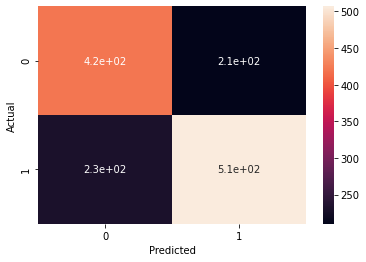

In [24]:
sns.heatmap(confusion_matrix, annot=True)
plt.show()

The accuracy score for this model is 67.8%

In [25]:
accuracy_score(result_df['actual'], result_df['predicted'])

0.6776075857038658